Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [75]:
from math import sqrt
from itertools import permutations
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [93]:
class Tsp:

    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]['pos']
        pos2 = self._graph.nodes[n2]['pos']
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0])**2 +
                                                         (pos1[1] - pos2[1])**2))

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def distance_matrix(self, solution: np.array) -> np.array:
        dm = np.zeros((len(solution),len(solution)))
        tmp = solution.tolist() + [solution[0]]
        for n1  in range(len(tmp) - 1):
            for n2  in range(len(tmp) - 1):
                dm[n1,n2] = self.distance(n1, n2)
        return dm

    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(self._graph,
                pos=nx.get_node_attributes(self._graph, 'pos'),
                with_labels=True,
                node_color='pink')
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

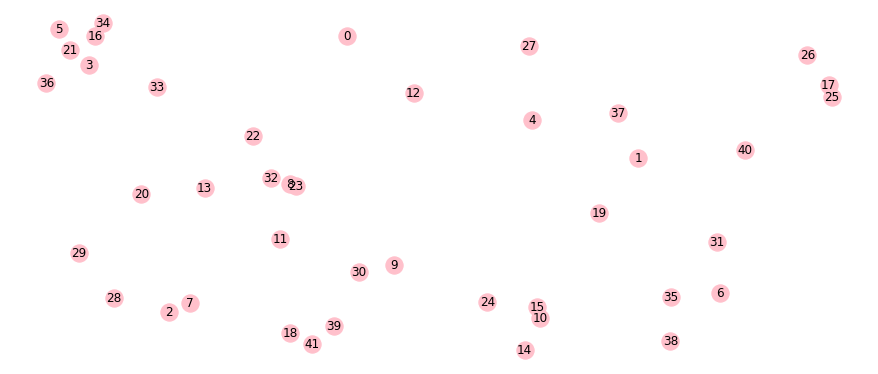

In [109]:
NUM_CITIES = 42

problem = Tsp(NUM_CITIES)
problem.plot()

In [44]:
def tweak1(solution: np.array, *, pm: float = .1) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, solution.shape[0])
        i2 = np.random.randint(0, solution.shape[0])
        temp = new_solution[i1]
        new_solution[i1] = new_solution[i2]
        new_solution[i2] = temp
        p = np.random.random()
    return new_solution

def tweak2(solution: np.array, problem, pm: float = 1/NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    best = solution.copy()
    p = None
    while p is None or p < pm:
        for i in range(1, len(solution) - 2):
            for j in range(i + 1, len(solution)):
                if j - i == 1: continue
                new_solution[i:j] = solution[j - 1:i - 1:-1]
                if problem.evaluate_solution(new_solution) < problem.evaluate_solution(best):
                    best[i:j] = best[j - 1:i - 1:-1]
        p = np.random.random()
    return best

In [152]:
import time

class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0,choose_best=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param evaporation_rate: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param choose_best: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.choose_best = choose_best

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.set_of_available_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1], "Map is not a distance matrix!"
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0

        self.heuristic_matrix = np.zeros((num_nodes,num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                self.heuristic_matrix[i,j] = 1 / self.map[i,j] if i!=j else 0
        
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)  # element by element multiplcation
        self.set_of_available_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.set_of_available_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_choose_best, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node, self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.set_of_available_nodes.remove(node)

    def _evaluate(self, paths):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)

            best = np.argmin(scores)

        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.
        """
        self.pheromone_matrix *= (1 - self.evaporation_rate)

    def _intensify(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def fit(self, map_matrix, iterations=100, early_stopping_count=20, verbose=True):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman Problem in mind.
        :param map_matrix: distance matrix
        :param iterations: number of iterations
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best path
        """
        if verbose: print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.set_of_available_nodes[np.random.randint(0, len(self.set_of_available_nodes))]
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.set_of_available_nodes) != 0:
                        current_node_index = self._choose_next_node(current_node)
                        current_node = self.set_of_available_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(paths)

            if i == 0:
                best_score_so_far = best_score
            else:
                if best_score < best_score_so_far:
                    best_score_so_far = best_score
                    self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._intensify(best_path_coords)
            self._update_probabilities()

            if verbose: print("Best score at iteration {}: {}; overall: {} ({}s)"
                              "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                        round(time.time() - start_iter)))

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                if verbose: print("Stopping early due to {} iterations of the same score.".format(early_stopping_count))
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        self.best = self.best_series[np.argmin(self.best_series)]
        if verbose: print(
            "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
        return self.best_path[:-1]

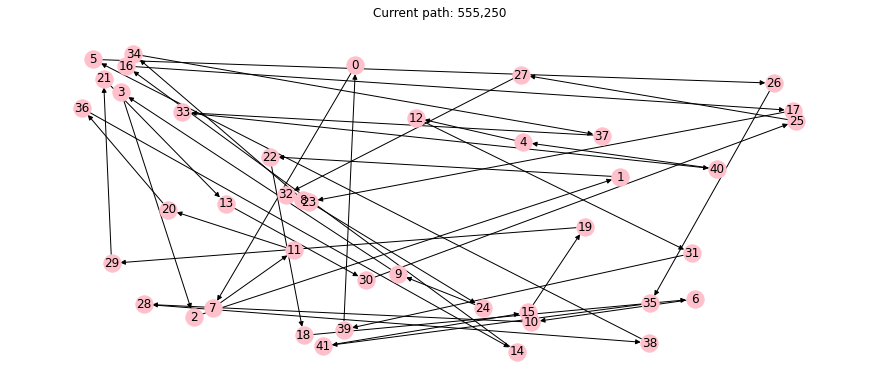

Beginning ACO Optimization with 1000 iterations...
Best score at iteration 0: 253468.0; overall: 253468.0 (0s)
Best score at iteration 1: 255988.0; overall: 253468.0 (0s)
Best score at iteration 2: 262766.0; overall: 253468.0 (0s)
Best score at iteration 3: 253376.0; overall: 253376.0 (0s)
Best score at iteration 4: 248919.0; overall: 248919.0 (0s)
Best score at iteration 5: 221329.0; overall: 221329.0 (0s)
Best score at iteration 6: 207701.0; overall: 207701.0 (0s)
Best score at iteration 7: 228051.0; overall: 207701.0 (0s)
Best score at iteration 8: 205338.0; overall: 205338.0 (0s)
Best score at iteration 9: 195148.0; overall: 195148.0 (0s)
Best score at iteration 10: 211395.0; overall: 195148.0 (0s)
Best score at iteration 11: 187058.0; overall: 187058.0 (0s)
Best score at iteration 12: 176901.0; overall: 176901.0 (0s)
Best score at iteration 13: 186872.0; overall: 176901.0 (1s)
Best score at iteration 14: 193198.0; overall: 176901.0 (0s)
Best score at iteration 15: 188336.0; overal

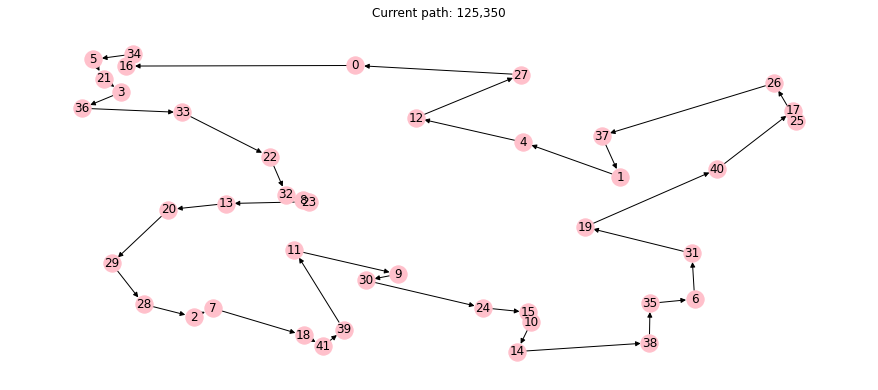

In [156]:
solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
problem.plot(solution)

dm = problem.distance_matrix(solution)
optimizer = AntColonyOptimizer(ants=100, evaporation_rate=.1, intensification=2, alpha=1, beta=1, choose_best=0.1)
 
solution = optimizer.fit(dm, iterations=1000)
print("Best path:\n{}".format(solution))
problem.plot(np.array(solution))
